# TA-10: Simulasi Sistem Kaku (Stiff ODE) – Reaksi Kimia Robertson
 Nama : Roy Bakti Surya Medal
 NIM  : 301230061
 Kelas: IF-5B

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# =========================================================
# 1) Definisi Model Robertson (Stiff ODE)
# =========================================================

In [2]:
def robertson(t, y):
    y1, y2, y3 = y
    dy1 = -0.04*y1 + 1e4*y2*y3
    dy2 =  0.04*y1 - 1e4*y2*y3 - 3e7*(y2**2)
    dy3 =  3e7*(y2**2)
    return [dy1, dy2, dy3]

y0 = [1.0, 0.0, 0.0]
print("y0 =", y0, "sum =", sum(y0))

y0 = [1.0, 0.0, 0.0] sum = 1.0


# =========================================================
# 2) Eksperimen Kegagalan Metode Eksplisit (Euler)
# =========================================================

Euler steps: 4
Last y: [-4.46612374e+07 -1.33893399e+11  1.33938060e+11] sum= 0.9999847412109375
Any negative? True Any NaN/Inf? False


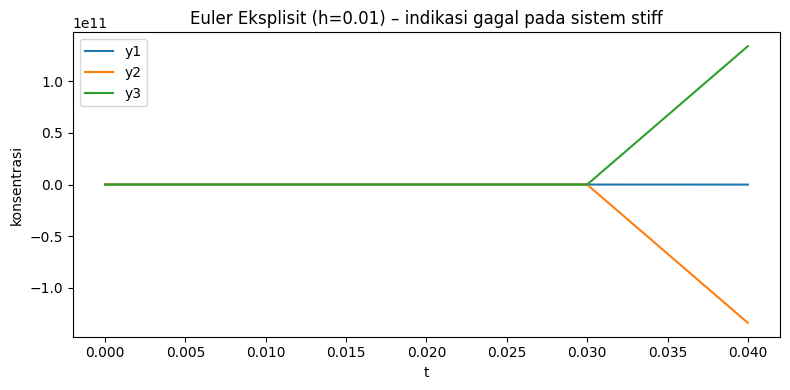

In [3]:
def euler_explicit(f, t0, y0, t_end, h):
    t_values = [t0]
    y_values = [np.array(y0, dtype=float)]
    t = t0
    y = np.array(y0, dtype=float)

    n_steps = int(np.ceil((t_end - t0)/h))
    for _ in range(n_steps):
        y = y + h*np.array(f(t, y))
        t = t + h
        t_values.append(t)
        y_values.append(y.copy())

        # stop early if numerical blow-up
        if (not np.all(np.isfinite(y))) or np.any(np.abs(y) > 1e6):
            break

    return np.array(t_values), np.vstack(y_values)

h = 1e-2
t_e, y_e = euler_explicit(robertson, 0.0, y0, t_end=1.0, h=h)
print("Euler steps:", len(t_e)-1)
print("Last y:", y_e[-1], "sum=", y_e[-1].sum())
print("Any negative?", (y_e < 0).any(), "Any NaN/Inf?", (not np.isfinite(y_e).all()))

plt.figure(figsize=(8,4))
plt.plot(t_e, y_e[:,0], label="y1")
plt.plot(t_e, y_e[:,1], label="y2")
plt.plot(t_e, y_e[:,2], label="y3")
plt.title(f"Euler Eksplisit (h={h}) – indikasi gagal pada sistem stiff")
plt.xlabel("t")
plt.ylabel("konsentrasi")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 3) solve_ivp: RK45 (pendek) vs Stiff Solver (panjang)
# =========================================================

RK45  : The solver successfully reached the end of the integration interval. nfev= 729668 time= 7.849945783615112 t_end= 100.0
Radau : The solver successfully reached the end of the integration interval. nfev= 1483 time= 0.08022522926330566 t_end= 100000.0
BDF   : The solver successfully reached the end of the integration interval. nfev= 895 time= 0.07048773765563965 t_end= 100000.0


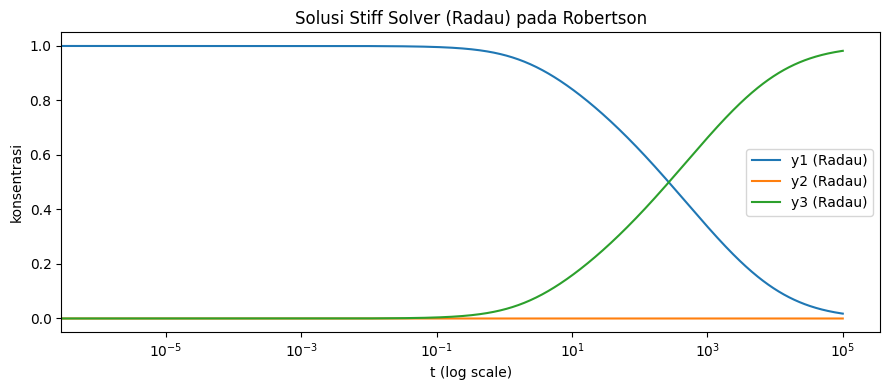

In [4]:
t_eval_long = np.concatenate(([0.0], np.logspace(-6, 5, 999)))

def run_solver(method, t_span, t_eval=None, rtol=1e-6, atol=1e-10):
    start = time.time()
    sol = solve_ivp(
        robertson, t_span, y0,
        method=method,
        t_eval=t_eval,
        rtol=rtol, atol=atol
    )
    elapsed = time.time() - start
    return sol, elapsed

# Rentang panjang (untuk solver stiff)
t_span_long = (0.0, 1e5)
sol_radau, t_radau = run_solver("Radau", t_span_long, t_eval=t_eval_long)
sol_bdf,   t_bdf   = run_solver("BDF",   t_span_long, t_eval=t_eval_long)

# Rentang pendek (RK45 hanya sebagai pembanding eksplisit)
t_span_short = (0.0, 100.0)  # bisa 1.0 / 1e3 sesuai kebutuhan
sol_rk45, t_rk45 = run_solver("RK45", t_span_short, t_eval=None)

print("RK45  :", sol_rk45.message,  "nfev=", sol_rk45.nfev,  "time=", t_rk45,  "t_end=", t_span_short[1])
print("Radau :", sol_radau.message, "nfev=", sol_radau.nfev, "time=", t_radau, "t_end=", t_span_long[1])
print("BDF   :", sol_bdf.message,   "nfev=", sol_bdf.nfev,   "time=", t_bdf,   "t_end=", t_span_long[1])

# Plot solusi Radau (panjang) dengan skala log di sumbu x
plt.figure(figsize=(9,4))
plt.semilogx(sol_radau.t, sol_radau.y[0], label="y1 (Radau)")
plt.semilogx(sol_radau.t, sol_radau.y[1], label="y2 (Radau)")
plt.semilogx(sol_radau.t, sol_radau.y[2], label="y3 (Radau)")
plt.title("Solusi Stiff Solver (Radau) pada Robertson")
plt.xlabel("t (log scale)")
plt.ylabel("konsentrasi")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 4) Grafik Perbandingan Awal Waktu: Euler vs Radau
# =========================================================

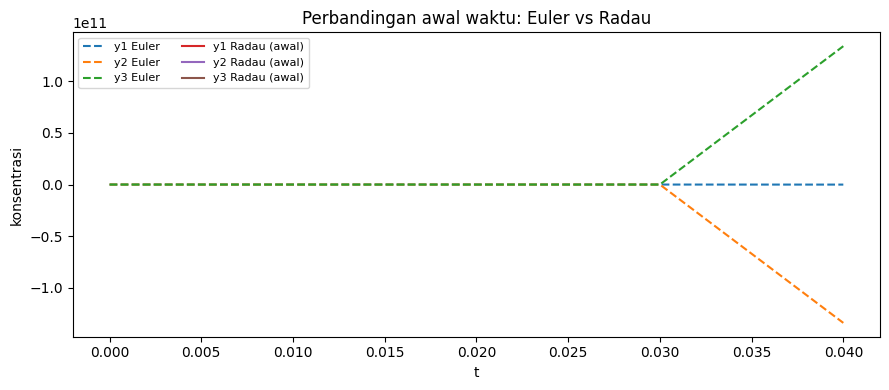

In [5]:
plt.figure(figsize=(9,4))
plt.plot(t_e, y_e[:,0], "--", label="y1 Euler")
plt.plot(t_e, y_e[:,1], "--", label="y2 Euler")
plt.plot(t_e, y_e[:,2], "--", label="y3 Euler")

# Ambil sebagian titik awal Radau untuk dibandingkan di waktu kecil
k = min(80, len(sol_radau.t))
plt.plot(sol_radau.t[:k], sol_radau.y[0][:k], label="y1 Radau (awal)")
plt.plot(sol_radau.t[:k], sol_radau.y[1][:k], label="y2 Radau (awal)")
plt.plot(sol_radau.t[:k], sol_radau.y[2][:k], label="y3 Radau (awal)")

plt.title("Perbandingan awal waktu: Euler vs Radau")
plt.xlabel("t")
plt.ylabel("konsentrasi")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# =========================================================
# 5) Tabel Kinerja
# =========================================================

In [6]:
rows = [
    {"Metode": f"Euler eksplisit (h={h})", "Waktu (detik)": np.nan,   "nfev": len(t_e)-1,
     "Status": "Gagal/Instabil (indikasi)"},
    {"Metode": f"RK45 (t_end={t_span_short[1]})", "Waktu (detik)": t_rk45, "nfev": sol_rk45.nfev,
     "Status": "Berhasil" if sol_rk45.success else "Gagal"},
    {"Metode": "Radau (t_end=1e5)", "Waktu (detik)": t_radau, "nfev": sol_radau.nfev,
     "Status": "Berhasil" if sol_radau.success else "Gagal"},
    {"Metode": "BDF (t_end=1e5)",   "Waktu (detik)": t_bdf,   "nfev": sol_bdf.nfev,
     "Status": "Berhasil" if sol_bdf.success else "Gagal"},
]

df = pd.DataFrame(rows)
df

,Metode,Waktu (detik),nfev,Status
0,Euler eksplisit (h=0.01),NaN,4,Gagal/Instabil (indikasi)
1,RK45 (t_end=100.0),7.849946,729668,Berhasil
2,Radau (t_end=1e5),0.080225,1483,Berhasil
3,BDF (t_end=1e5),0.070488,895,Berhasil
